# Algorithmic trading with Keras (using LSTM)

We use a Long Short Time Memory recurrent neural network to develop a good trading strategy for the S&P 500 index: the first trading day of each month we want our model to tell us if we are going to stay in the market for the current month or not.

We verify that, in a period of 4 years which comprehends the 2008 crisis, this LSTM-trading-strategy is far better than the buy and hold strategy (stay always in the market) and the moving average strategy (buy when the current price is greater or equal to the moving average of past 12 months and sell otherwise). 

We compute the gross and net yield (as it is by the Italian law: 26% tax on capital gain and 0.10% fee to the broker at each transaction): our model performed roughly a 10% net annual yield (which is not bad, considering the 2008 crisis)

In [1]:
from __future__ import division
import pandas as pd
import numpy as np
import datetime
import time
import matplotlib.pyplot as plt

import keras
from keras.models import Sequential
from keras.layers import Dense,Dropout,BatchNormalization,Conv1D,Flatten,MaxPooling1D,LSTM
from keras.callbacks import EarlyStopping,ModelCheckpoint,TensorBoard
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler

## Part 1: Get the data 

I used Yahoo Finance to get the data of the S&P 500 index from 1973/1/1 to 2011/3/31. Our analysis is monthly-based, and all the decisions are made the first trading day of the month.
For a reason which will be clarified by the following code, our analysis will start from 24 months after January 1973 and end the month before March 2011.

Since it is not possible to use Yahoo Finance on this kernel, I saved the data in "GSPC.csv". I still left the original code commented.


In [2]:
start_date=datetime.datetime(2016,1,6)
end_date=datetime.datetime(2021,1,5)

df=pd.read_csv("AAPL.csv")
df.index=pd.to_datetime(df["Date"])
df=df.drop("Date",axis=1)

In [3]:
#df = pdr.get_data_yahoo('^GSPC', start=start_date, end=end_date)
#df.drop("Adj Close",axis=1,inplace=True)
#df.to_csv("GSPC.csv")

In order to develop our trading strategy, we need to obtain a dataframe with the monthly means and the first trading day of the month price. First we obtain the monthly means

In [4]:
# dfm=df.resample("M").mean()
dfm=df

# dfm=dfm[:-1] # As we said, we do not consider the month of end_date

Then we obtain the list of the first trading day for each month

In [5]:
# start_year=start_date.year
# start_month=start_date.month
# end_year=end_date.year
# end_month=end_date.month

# first_days=[]
# # First year
# for month in range(start_month,13):
#     first_days.append(min(df[str(start_year)+"-"+str(month)].index))
# # Other years
# for year in range(start_year+1,end_year):
#     for month in range(1,13):
#         first_days.append(min(df[str(year)+"-"+str(month)].index))
# # Last year
# for month in range(1,end_month+1):
#     first_days.append(min(df[str(end_year)+"-"+str(month)].index))

Now for each month we have the means of the month, the first trading day of the current month (and its open price) and the first trading day of the next month (and its open price).

The feature *rapp* is the quotient between the open price of the first trading day of the next month and the open price of the first trading day of the current month. It will be used because it gives the variation of the portfolio for the current month

In [6]:
# dfm["fd_cm"]=first_days[:-1]
# dfm["fd_nm"]=first_days[1:]
# dfm["fd_cm_open"]=np.array(df.loc[first_days[:-1],"Open"])
# dfm["fd_nm_open"]=np.array(df.loc[first_days[1:],"Open"])
dfm["rapp"]=dfm["Close"].divide(dfm["Open"])

In [7]:
dfm.head(10)

,Open,High,Low,Close,Adj Close,Volume,rapp
Date,,,,,,,
2016-01-06,25.139999,25.592501,24.967501,25.174999,23.323915,273829600,1.001392
2016-01-07,24.670000,25.032499,24.107500,24.112499,22.339539,324377600,0.977402
2016-01-08,24.637501,24.777500,24.190001,24.240000,22.457672,283192000,0.983866
2016-01-11,24.742500,24.764999,24.334999,24.632500,22.821304,198957600,0.995554
2016-01-12,25.137501,25.172501,24.709999,24.990000,23.152521,196616800,0.994132
2016-01-13,25.080000,25.297501,24.325001,24.347500,22.557264,249758400,0.970793
2016-01-14,24.490000,25.120001,23.934999,24.879999,23.050606,252680400,1.015925
2016-01-15,24.049999,24.427500,23.840000,24.282499,22.497040,319335600,1.009667
2016-01-19,24.602501,24.662500,23.875000,24.165001,22.388184,212350800,0.982217


In [8]:
print(dfm.head())
print(dfm.tail())

                 Open       High        Low      Close  Adj Close     Volume  \
Date                                                                           
2016-01-06  25.139999  25.592501  24.967501  25.174999  23.323915  273829600   
2016-01-07  24.670000  25.032499  24.107500  24.112499  22.339539  324377600   
2016-01-08  24.637501  24.777500  24.190001  24.240000  22.457672  283192000   
2016-01-11  24.742500  24.764999  24.334999  24.632500  22.821304  198957600   
2016-01-12  25.137501  25.172501  24.709999  24.990000  23.152521  196616800   

                rapp  
Date                  
2016-01-06  1.001392  
2016-01-07  0.977402  
2016-01-08  0.983866  
2016-01-11  0.995554  
2016-01-12  0.994132  
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2020-12-29  138.050003  138.789993  134.339996  134.869995  134.869995   
2020-12-30  135.580002  135.990005  133.399994  133.7200

Now we add the columns corresponding to the moving averages at 1 and 2 years

In [9]:
dfm["mv_avg_12"]= dfm["Close"].rolling(window=5).mean().shift(1)
dfm["mv_avg_24"]= dfm["Close"].rolling(window=50).mean().shift(1)

Note that in this way each month of dfm contains the moving averages of the previous 12 and 24 months (excluding the current month)

In [10]:
print(dfm.loc["2020-12","mv_avg_12"])
print(dfm.loc["2019-12":"2020-11","Open"])
print(dfm.loc["2019-12":"2020-11","Open"].mean())

Date
2020-12-01    116.137999
2020-12-02    117.911999
2020-12-03    119.494000
2020-12-04    120.876001
2020-12-07    122.008002
2020-12-08    122.948001
2020-12-09    123.280000
2020-12-10    123.020000
2020-12-11    123.079999
2020-12-14    123.112000
2020-12-15    122.717999
2020-12-16    123.417999
2020-12-17    124.623999
2020-12-18    125.715999
2020-12-21    126.565999
2020-12-22    127.855998
2020-12-23    128.656000
2020-12-24    129.286002
2020-12-28    129.940003
2020-12-29    131.946002
2020-12-30    133.274002
2020-12-31    133.642001
Name: mv_avg_12, dtype: float64
Date
2019-12-02     66.817497
2019-12-03     64.577499
2019-12-04     65.267502
2019-12-05     65.947502
2019-12-06     66.870003
                 ...    
2020-11-23    117.180000
2020-11-24    113.910004
2020-11-25    115.550003
2020-11-27    116.570000
2020-11-30    116.970001
Name: Open, Length: 252, dtype: float64
90.28259934920635


We remove the first 24 months, since they do not have the 2-year moving average

In [11]:
dfm=dfm.iloc[50:,:] # WARNING: DO IT JUST ONE TIME!
print(dfm.index)

DatetimeIndex(['2016-03-18', '2016-03-21', '2016-03-22', '2016-03-23',
               '2016-03-24', '2016-03-28', '2016-03-29', '2016-03-30',
               '2016-03-31', '2016-04-01',
               ...
               '2020-12-21', '2020-12-22', '2020-12-23', '2020-12-24',
               '2020-12-28', '2020-12-29', '2020-12-30', '2020-12-31',
               '2021-01-04', '2021-01-05'],
              dtype='datetime64[ns]', name='Date', length=1209, freq=None)


Finally, we can divide *dfm* in train and test set

In [12]:
len(dfm)

1209

In [13]:
mtest=252
train=dfm.iloc[:-mtest,:] 
test=dfm.iloc[-mtest:,:] 

## Part 2: Define functions to compute gross and net yield

Notice that the gross yield can be computed very easily using the feature *rapp*.
The following function explains how: the vector v selects which months we are going to stay in the market

In [14]:
# This function returns the total percentage gross yield and the annual percentage gross yield

def yield_gross(df,v):
    prod=(v*df["rapp"]+1-v).prod()
    n_years=len(v)/252
    return (prod-1)*100,((prod**(1/n_years))-1)*100

We just need to define a function to compute the net yield, considering (as it is by the Italian law) a 26% tax on capital gain and 0.10% commission to the broker at each transaction

In [15]:
tax_cg=0
comm_bk=0

In [16]:
# This function will be used in the function yield_net

# Given any vector v of ones and zeros, this function gives the corresponding vectors of "islands" of ones of v
# and their number. 
# For example, given v = [0,1,1,0,1,0,1], expand_islands2D gives
# out2D = [[0,1,1,0,0,0,0],[0,0,0,0,1,0,0],[0,0,0,0,0,0,1]] and N=3

def expand_islands2D(v):
    
    # Get start, stop of 1s islands
    v1 = np.r_[0,v,0]
    idx = np.flatnonzero(v1[:-1] != v1[1:])
    s0,s1 = idx[::2],idx[1::2]
    if len(s0)==0:
        return np.zeros(len(v)),0
    
    # Initialize 1D id array  of size same as expected o/p and has 
    # starts and stops assigned as 1s and -1s, so that a final cumsum
    # gives us the desired o/p
    N,M = len(s0),len(v)
    out = np.zeros(N*M,dtype=int)

    # Setup starts with 1s
    r = np.arange(N)*M
    out[s0+r] = 1


    # Setup stops with -1s
    if s1[-1] == M:
        out[s1[:-1]+r[:-1]] = -1
    else:
        out[s1+r] -= 1

    # Final cumsum on ID array
    out2D = out.cumsum().reshape(N,-1)
    return out2D,N

Again, the vector v selects which months we are going to stay in the market

In [17]:
# This function returns the total percentage net yield and the annual percentage net yield

def yield_net(df,v):
    n_years=len(v)/252
    
    w,n=expand_islands2D(v)
    A=(w*np.array(df["rapp"])+(1-w)).prod(axis=1)  # A is the product of each island of ones of 1 for df["rapp"]
    A1p=np.maximum(0,np.sign(A-1)) # vector of ones where the corresponding element if  A  is > 1, other are 0
    Ap=A*A1p # vector of elements of A > 1, other are 0
    Am=A-Ap # vector of elements of A <= 1, other are 0
    An=Am+(Ap-A1p)*(1-tax_cg)+A1p
    prod=An.prod()*((1-comm_bk)**(2*n)) 
    
    return (prod-1)*100,((prod**(1/n_years))-1)*100   

## Part 3: Define the LSTM model

We want to use a LSTM neural network to decide, the first day of each day of the test period, whether we are going to stay in the market for the month or not.

We reshape the data (the LSTM wants the data in a particular shape, involving "windows") and at each step we want to predict the opening price of the first day of the next month: in this way we will be able to find the vector v which selects the months during which we are going to stay in the market

In [18]:
def create_window(data, window_size = 1):    
    data_s = data.copy()
    for i in range(window_size):
        data = pd.concat([data, data_s.shift(-(i + 1))], axis = 1)
        
    data.dropna(axis=0, inplace=True)
    return(data)

In [26]:
scaler=MinMaxScaler(feature_range=(0,1))
dg=pd.DataFrame(scaler.fit_transform(dfm[["High","Low","Open","Close","Volume",\
                                          "mv_avg_12","mv_avg_24"]].values))
dg0=dg[[0,1,2,3,4,5]]


window=4
dfw=create_window(dg0,window)

X_dfw=np.reshape(dfw.values,(dfw.shape[0],window+1,6))
#X_dfw=np.reshape(dfw.values,(dfw.shape[0],window+1,6))
#print(X_dfw.shape)
#print(dfw.iloc[:4,:])
#print(X_dfw[0,:,:])

y_dfw=np.array(dg[6][window:]) # The Fix

In [27]:
dg[6][window:]

4       0.007880
5       0.008173
6       0.008574
7       0.008993
8       0.009631
          ...   
1204    0.987403
1205    0.990660
1206    0.994305
1207    0.997424
1208    1.000000
Name: 6, Length: 1205, dtype: float64

In [28]:
dfw.tail(5)

,0,1,2,3,4,5,0,1,2,3,...,2,3,4,5,0,1,2,3,4,5
1200,0.962200,0.958115,0.944267,0.957846,0.333253,0.944761,0.945112,0.968207,0.949026,0.949783,...,0.964864,1.000000,0.230954,0.963535,1.000000,1.000000,1.000000,0.984050,0.223034,0.981605
1201,0.945112,0.968207,0.949026,0.949783,0.147439,0.951968,0.954001,0.971064,0.941757,0.958635,...,1.000000,0.984050,0.223034,0.981605,0.975836,0.991605,0.978624,0.973971,0.166390,0.993568
1202,0.954001,0.971064,0.941757,0.958635,0.070762,0.957643,0.987486,0.992587,0.964864,1.000000,...,0.978624,0.973971,0.166390,0.993568,0.965048,0.976601,0.965643,0.964945,0.172236,0.996883
1203,0.987486,0.992587,0.964864,1.000000,0.230954,0.963535,1.000000,1.000000,1.000000,0.984050,...,0.965643,0.964945,0.172236,0.996883,0.955296,0.932305,0.960796,0.936199,0.274288,1.000000
1204,1.000000,1.000000,1.000000,0.984050,0.223034,0.981605,0.975836,0.991605,0.978624,0.973971,...,0.960796,0.936199,0.274288,1.000000,0.939157,0.947219,0.920727,0.950221,0.169183,0.995388


In [29]:
# X_trainw=X_dfw[:-mtest-1,:,:]
# X_testw=X_dfw[-mtest-1:,:,:]
# y_trainw=y_dfw[:-mtest-1]
# y_testw=y_dfw[-mtest-1:]

X_trainw=X_dfw[:-mtest-1,:,:]
X_testw=X_dfw[-mtest-1:,:,:]
y_trainw=y_dfw[:-mtest-1]
y_testw=y_dfw[-mtest-1:]

In [30]:
def model_lstm(window,features):
    
    model=Sequential()
    model.add(LSTM(300, input_shape = (window,features), return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(200, input_shape=(window,features), return_sequences=False))
    model.add(Dropout(0.5))
    model.add(Dense(100,kernel_initializer='uniform',activation='relu'))        
    model.add(Dense(1,kernel_initializer='uniform',activation='relu'))
    model.compile(loss='mse',optimizer='adam')
    
    
    return model

In [31]:
len(X_dfw)

1205

In [32]:
len(y_dfw)

1205

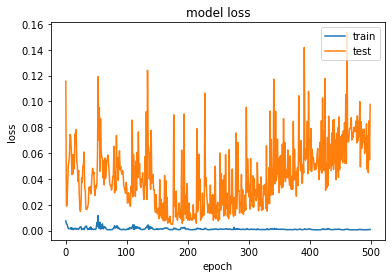

In [33]:
model=model_lstm(window+1,6)
history=model.fit(X_trainw,y_trainw,epochs=500, batch_size=50, validation_data=(X_testw, y_testw), \
                  verbose=0, callbacks=[],shuffle=False) # Batch size was 24

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [34]:
y_pr=model.predict(X_trainw)

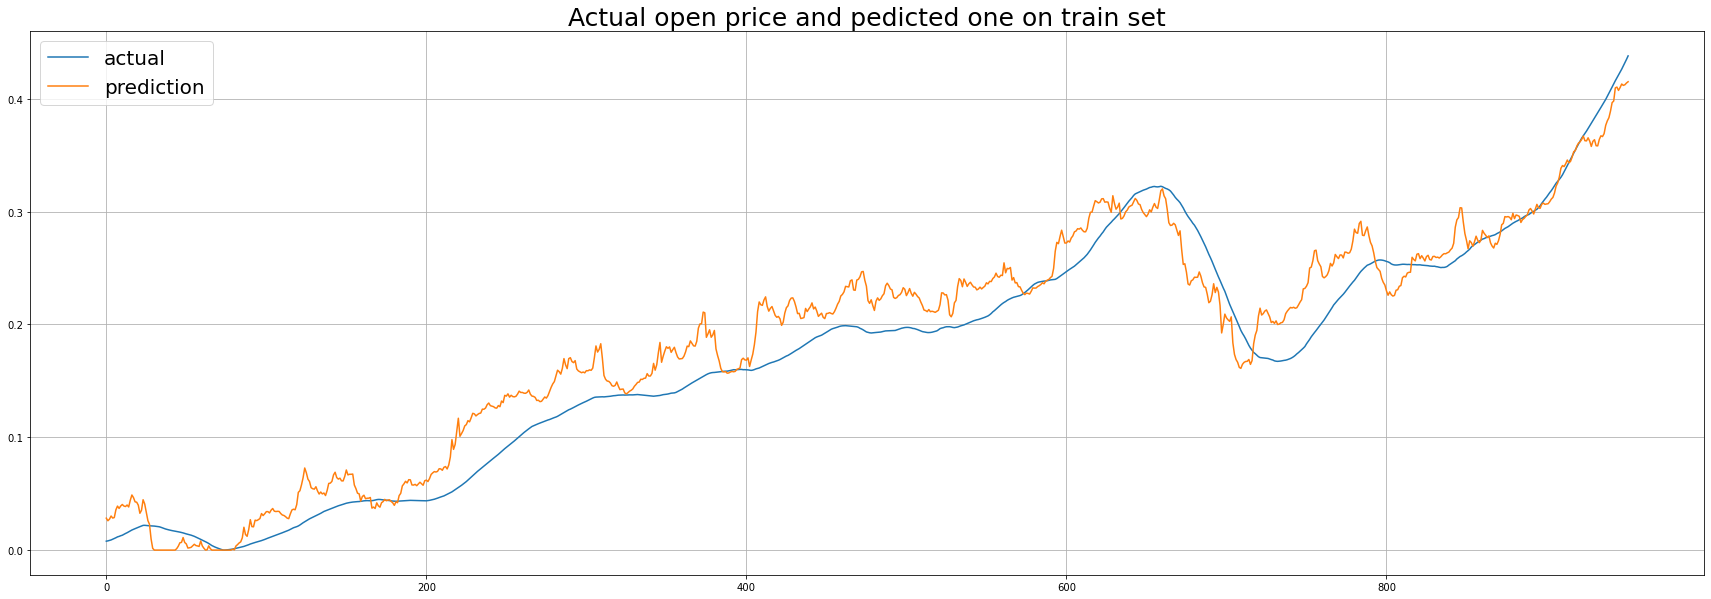

In [35]:
plt.figure(figsize=(30,10))
plt.plot(y_trainw, label="actual")
plt.plot(y_pr, label="prediction")
plt.legend(fontsize=20)
plt.grid(axis="both")
plt.title("Actual open price and pedicted one on train set",fontsize=25)
plt.show()

In [36]:
y_pred=model.predict(X_testw)

**We stay in the market when the predicted price for the next month is greater than the current price and stay out otherwise. The vector v indicates the "in months" (as 1s) and "out months" (as 0s)**

In [37]:
v=np.diff(y_pred.reshape(y_pred.shape[0]),1)
v_lstm=np.maximum(np.sign(v),0)

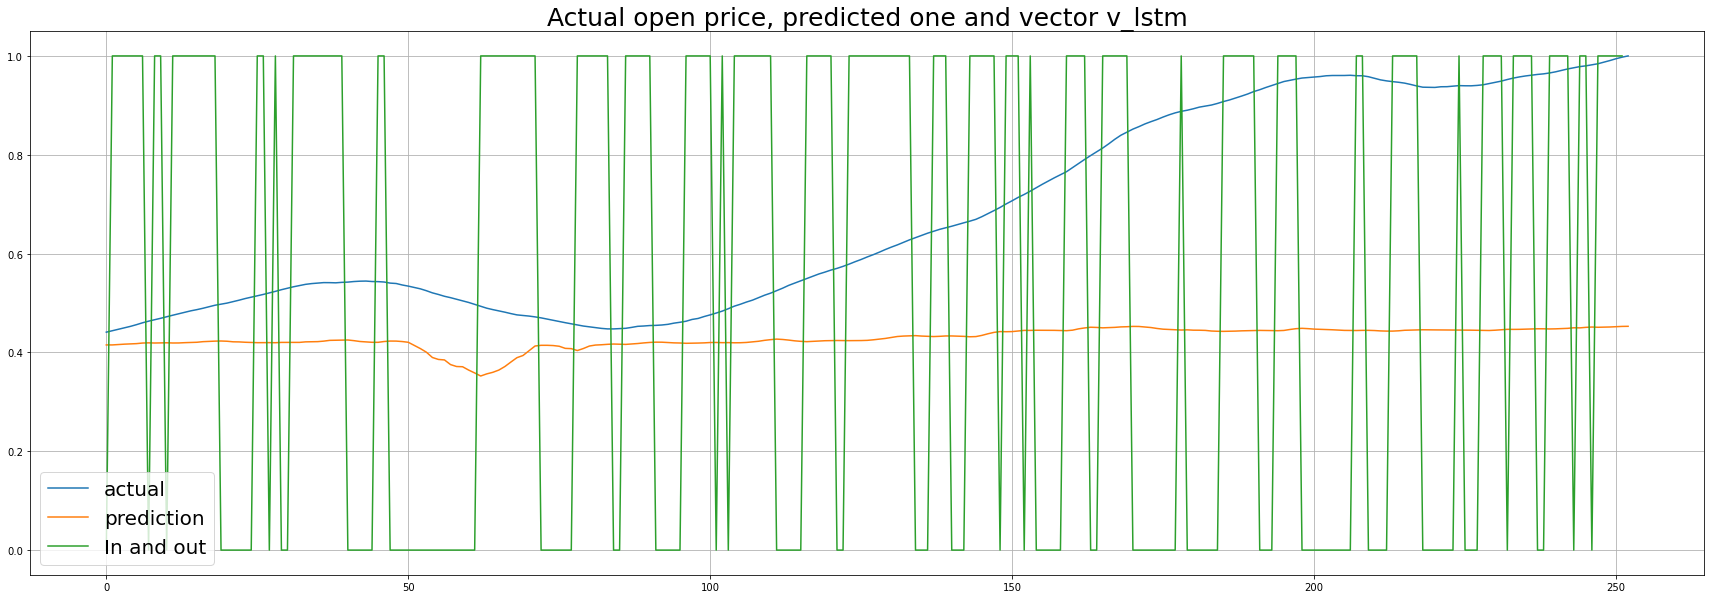

In [38]:
plt.figure(figsize=(30,10))
plt.plot(y_testw, label="actual")
plt.plot(y_pred, label="prediction")
plt.plot(v_lstm,label="In and out")
plt.legend(fontsize=20)
plt.grid(axis="both")
plt.title("Actual open price, predicted one and vector v_lstm",fontsize=25)
plt.show()

**The preceeding plot shows an interesting feature of the prediction of our model: it is quite good at predicting the sign of the first derivative of the index, but this is exactly what we need for our trading strategy!** 

## Part 4: Compare the LSTM method with other methods

Now we can copare our LSTM-trading-strategy with the buy and hold strategy and the moving average strategy. In order to do so we compute the corresponding vectors v_bh and v_ma which select the months during which we are going to stay in the market.

In [39]:
v_bh=np.ones(test.shape[0])
v_ma=test["Open"]>test["mv_avg_12"]

In [40]:
def gross_portfolio(df,w):
    portfolio=[ (w*df["rapp"]+(1-w))[:i].prod() for i in range(len(w))]
    return portfolio

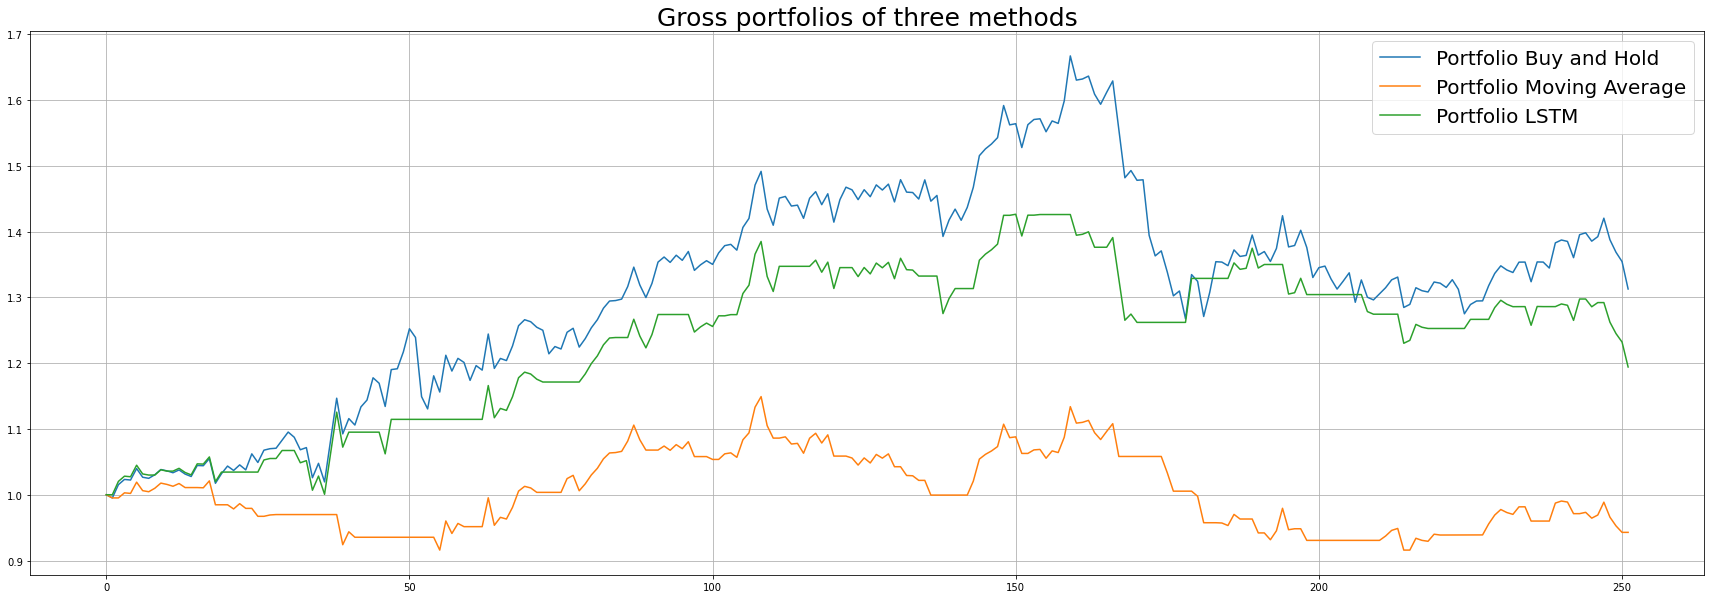

In [41]:
plt.figure(figsize=(30,10))
plt.plot(gross_portfolio(test,v_bh),label="Portfolio Buy and Hold")
plt.plot(gross_portfolio(test,v_ma),label="Portfolio Moving Average")
plt.plot(gross_portfolio(test,v_lstm),label="Portfolio LSTM")
plt.legend(fontsize=20)
plt.grid(axis="both")
plt.title("Gross portfolios of three methods", fontsize=25)
plt.show()

In [42]:
len(v_bh)

252

In [43]:
print("Test period of {:.2f} years, from {} to {} \n".format(len(v_bh)/365,str(test.loc[test.index[0],"Open"])[:10],\
      str(test.loc[test.index[-1],"Close"])[:10])) # Divide by 365 versus 12

results0=pd.DataFrame({})
results1=pd.DataFrame({})
results2=pd.DataFrame({})
results3=pd.DataFrame({})

results0["Method"]=["Buy and hold","Moving average","LSTM"]
results1["Method"]=["Buy and hold","Moving average","LSTM"]
results2["Method"]=["Buy and hold","Moving average","LSTM"]
results3["Method"]=["Buy and hold","Moving average","LSTM"]

vs=[v_bh,v_ma,v_lstm]
results0["Total gross yield"]=[str(round(yield_gross(test,vi)[0],2))+" %" for vi in vs]
results1["Annual gross yield"]=[str(round(yield_gross(test,vi)[1],2))+" %" for vi in vs]
results2["Total net yield"]=[str(round(yield_net(test,vi)[0],2))+" %" for vi in vs]
results3["Annual net yield"]=[str(round(yield_net(test,vi)[1],2))+" %" for vi in vs]

print(results0)
print("\n")
print(results1)
print("\n")
print(results2)
print("\n")
print(results3)

Test period of 0.69 years, from 74.959999 to 131.009995 

           Method Total gross yield
0    Buy and hold           33.44 %
1  Moving average           -5.72 %
2            LSTM           21.38 %


           Method Annual gross yield
0    Buy and hold            33.44 %
1  Moving average            -5.72 %
2            LSTM            21.38 %


           Method Total net yield
0    Buy and hold         33.44 %
1  Moving average         -5.72 %
2            LSTM         21.38 %


           Method Annual net yield
0    Buy and hold          33.44 %
1  Moving average          -5.72 %
2            LSTM          21.38 %
